<a href="https://colab.research.google.com/github/vilsonrodrigues/Projeto_Orientacao_Academica/blob/master/Projeto_Orientacao_Academica_Tratamento_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por @vilsonrodrigues



# <center><font color='blue'>Projeto de Orientação Acadêmica</font>




<img src='https://ufrn.br/resources/documentos/identidadevisual/logotipo/logotipo_flat.png'>

## Parte I - Apresentação do Problema
### [1. Apresentação do Problema](#apresentacao)
## Parte II - Preparativos Iniciais
### [1. Bibliotecas](#bibliotecas)
### [2. Classe](#classe)
### [3. Funções](#funcoes)
### [4. Leituras da Bases](#leiturabase)
## Parte III - Desenvolvimento
### [1. Entendimento dos Dados Primários](#enten_dados)
### [2. Preparação dos Dados](#preparo)
### [3. Exploração dos Novos Dados](#novos_dados)



# Parte I - Apresentação do Problema

### **Meta**
Nossa meta é prever através de Machine Learning as probabilidades de um estudante ter sucesso em uma disciplina dado o histórico escolar na Universidade.

Nossos dados foram transformados para ficarem de uma forma génerica, assim, não dependemos de saber qual foi a matéria cursada anteriormente.

Com essa plataforma, os professores que orientam alunos, terão mais segurança e uma comprovação com base no Machine Learning que estudantes que tiveram um histórico semelhante e seguiram esse caminho tiveram mais êxito do que seguir por este outro.

Os dados foram coletados do período de 2015.1 até 2019.1.

**Esse notebook foca totalmente em analisar os dados e montar uma estratégia  de gerar dados genéricos, de modo que fiquem independente de qual disciplina o aluno curso no semeste anterior.**

O trabalho continua neste [notebook](https://), onde são gerados modelos de Machine Learning com dados genéricos.

### **Fonte dos Dados**
Dados foram extraídos do portal SIGAA e fornecidos pela Escola de Ciências e Tecnlogia (ECT).

### **Referência**
Hands On: Machine Learning with Scikit-Learning e Tensor Flow



# Parte II - Preparativos Iniciais

## 1. Bibliotecas
<a id='bibliotecas'></a>
#### [1.1 Instalações](#instalacao)
#### [1.2 Importações](#importacao)


### 1.1. Instalação
<a id='instalacao'></a>

In [0]:
!pip install pandas -U
!pip install scikit-learn -U
!pip install numpy -U
!pip install joblib==0.14.1

### 1.2. Importação
<a id='importacao'></a>

In [0]:
#Utilizadas até agora
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import pandas as pd
import numpy as np

#Persistência em disco
import joblib
import pickle

#Visualização
import seaborn as sns
import matplotlib.pyplot as plt

#Transformadores e Modelador
from sklearn.pipeline          import Pipeline
from sklearn.base              import BaseEstimator, TransformerMixin

#Selecao de modelo
from sklearn.model_selection   import train_test_split
from sklearn.model_selection   import KFold
from sklearn.model_selection   import cross_val_score
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2

#modo não-perturbe
import warnings
warnings.filterwarnings("ignore")

##2. Classe
<a id='classe'></a>


Classe para realizar a geração de dados genéricos

In [0]:
class GeraDadosGenericos(TransformerMixin):  
  def __init__(self, carga):
    self.carga = carga

	#nao irei fazer nenhum treinamento	
  def fit(self, X, y = None):
    return self    

  #-------------------------funcoes de geracao de dados da classe---------------------------------

  def filtraSituacoes(self, df_notas):
    #conversao para string
    df_notas['matricula'] = df_notas['matricula'].astype(str)
    df_notas['periodo']   = df_notas['periodo'].astype(str)

    #substitui todas as situacoes de reprovado e aprovado para ser apenas um tipo
    df_notas.loc[df_notas['situacao'].str.contains('REPROVADO'), 'situacao'] = 'REPROVADO'
    df_notas.loc[df_notas['situacao'].str.contains('APROVADO'), 'situacao']  = 'APROVADO'

    #seleciona as situacoes de interesse que são aprovados e reprovados
    df_notas = df_notas.loc[(df_notas['situacao'].str.contains('APROVADO')) |
                            (df_notas['situacao'].str.contains('REPROVADO')) 
                           ] 	
                           
    #tem disciplina que só contam para a horas complementares, não tem nota
    df_notas = df_notas.loc[ ~(df_notas['nota'].str.contains('-')), :]

    #conversao para de string para float
    df_notas['nota'] = df_notas['nota'].astype(float)
    return df_notas


  def converteString(self, df_notas):
    df_notas['periodo']   = df_notas['periodo'].astype(str)
    return df_notas


  def concatenaSemestre(self, df_notas):
    #pega o ano mais alto que tem na matricula, indicando o semestre do df
    ano_df = df_notas['matricula'].str[0:4].max()
    df_notas['semestre'] = str(ano_df) + '.' + str(df_notas['periodo'].iloc[0])
    #apagando a coluna periodo, nao serve mais
    df_notas.drop(columns = ['periodo'], inplace=True)
    #conversao para float
    df_notas['semestre'] = df_notas['semestre'].astype(float)
    df_notas['matricula'] = df_notas['matricula'].astype(int)
    return df_notas

  #adiciona quanto tempo o estudante esta com a matricula vingente 
  def anosMatriculado(self, df_notas): 
    df_notas['matricula'] = df_notas['matricula'].astype(str)
    df_notas['anoIngresso'] = df_notas['matricula'].str[0:4]
    df_notas['anoIngresso'] = df_notas['anoIngresso'].astype(float)
    df_notas['semestre'] = df_notas['semestre'].astype(float)
    df_notas['anosMatriculado'] = df_notas['semestre'] - df_notas['anoIngresso']
    df_notas['anosMatriculado'] = df_notas['anosMatriculado'].astype(int)
    return df_notas    


  #essa função vai criar as novas features com o desempenho do aluno no semestre 
  def geraFeaturesComDadosGenericos(self, df_notas):
    df_notas = df_notas.merge(self.carga, on = 'codigo')
    df = pd.DataFrame()
    final = pd.DataFrame()

    #media das disciplinas
    df = df_notas.groupby('matricula')['nota'].mean().reset_index()
    df.rename(columns={'nota':'mediaNotas'}, inplace = True)
    final = df

    #menor nota
    df = df_notas.groupby('matricula')['nota'].min().reset_index()
    df.rename(columns = {'nota':'menorNota'}, inplace = True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #maior nota
    df = df_notas.groupby('matricula')['nota'].max().reset_index()
    df.rename(columns = {'nota':'maiorNota'}, inplace = True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #quantidade de disciplinas cursadas
    df = df_notas.groupby('matricula')['codigo'].count().reset_index()
    df.rename(columns = {'codigo':'quantidadeDisciplinasCursadas'}, inplace=True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #quantidade de situacoes
    df = df_notas.groupby(['matricula','situacao'])['codigo'].count().reset_index()
    df.rename(columns = {'codigo':'quanSituacao'}, inplace = True)

    #quantidade de situacoes em que houve aprovacao
    aprovado = df.loc[df['situacao'] == 'APROVADO',:]
    aprovado.rename(columns = {'quanSituacao':'quantidadeAprovacoes'}, inplace = True)
    final = final.merge(aprovado, on = 'matricula', how = 'outer')

    #quantidade de situacoes em que houve reprovacao
    reprovado = df.loc[df['situacao'] == 'REPROVADO',:]
    reprovado.rename(columns = {'quanSituacao':'quantidadeReprovacoes'}, inplace = True)
    final = final.merge(reprovado, on = 'matricula', how = 'outer')
    final = final.drop(['situacao_x', 'situacao_y'], axis = 1)

    #media das aprovacoes
    aprov = df_notas.loc[df_notas['situacao'] == 'APROVADO',:]
    dfa = aprov.groupby(['matricula'])['nota'].mean().reset_index()
    dfa.rename(columns = {'nota':'mediaAprovadas'}, inplace = True)
    final = final.merge(dfa, on = 'matricula', how ='outer')

    #media das reprovacoes
    reprov = df_notas.loc[df_notas['situacao'] == 'REPROVADO',:]
    dfr = reprov.groupby(['matricula'])['nota'].mean().reset_index()
    dfr.rename(columns = {'nota':'mediaReprovadas'}, inplace = True)
    final = final.merge(dfr, on = 'matricula', how ='outer')

    #carga horaria total no semestre
    df = df_notas.groupby('matricula')['ch_total'].sum().reset_index()
    df.rename(columns = {'ch_total':'cargaHoraria'}, inplace = True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #substituindo valores nulos por 0
    final = final.fillna(0)

    #conversao de campos de objeto para inteiro
    final['quantidadeAprovacoes']  = final['quantidadeAprovacoes'].astype(int)
    final['quantidadeReprovacoes'] = final['quantidadeReprovacoes'].astype(int)

    #Criando campo taxa de sucesso, que será a porcentagem de aprovações dado o total de disciplinas
    final['taxaDeSucesso']  = np.divide(final['quantidadeAprovacoes'], final['quantidadeDisciplinasCursadas']) 

    #herdando o semestre
    final['semestre'] = df_notas['semestre']

    return final

  #--------------------fim das funcoes de geracao de dados da classe-----------------------------------------


  def transform(self, X, y = None):
    #itera a lista
    lista_df_notas = X.copy()
    lista_df_generico = []
    lista_notas = []
    lista_de_listas = []
    for df_notas in lista_df_notas:
      df_notas = self.converteString(df_notas)
      df_notas = self.filtraSituacoes(df_notas)
      df_notas = self.concatenaSemestre(df_notas)
      lista_notas.append(df_notas)
      df_generico = self.geraFeaturesComDadosGenericos(df_notas)
      df_generico = self.anosMatriculado(df_generico)
      lista_df_generico.append(df_generico)

    lista_de_listas.append(lista_df_generico)  
    lista_de_listas.append(lista_notas)
    return lista_de_listas

**Classes para o treinamento do modelo**

Classe para concatenar os dados genéricos do semestre passado com o resultado final na disciplina no atual semestre

In [0]:
class ConcatenaSemestrePassadoComResultadosDoAtual(TransformerMixin):
  def __init__(self, data = None):
    return data

	#nao irei fazer nenhum treinamento	
  def fit(self, X, y = None):
    return self    

  #--------------------------------- funcoes de transformacao da classe -----------------------------------------
  def converteParaInt(self, df):
    df['matricula'] = df['matricula'].astype(int)
    return df


  def transformacoesSemestreAntecessor(self, semestreAntecessor):
    semestreAntecessor = self.converteParaInt(semestreAntecessor)
    semestreAntecessor.rename(columns = {'cargaHoraria':"cargaHorariaPassada",
                                         'semestre':'semestrePassado'}, 
                                        inplace=True) 
    return semestreAntecessor


  def transformacoesSemestreAtual(self, semestreAtual): 
    semestreAtual = self.converteParaInt(semestreAtual)
    #seleciona os campos que vou precisar
    semestreAtual = semestreAtual[['matricula','cargaHoraria','semestre','quantidadeDisciplinasCursadas','anosMatriculado']]
    semestreAtual.rename(columns = {'cargaHoraria':"cargaHorariaAtual",
                                    'quantidadeDisciplinasCursadas':'quantidadeDisciplinasAtuais',
                                    'semestre':'semestreAtual'}, 
                                    inplace=True) 
    return semestreAtual


  def transformacoesResultadoAtual(self, resultadoAtual):  
    resultadoAtual = self.converteParaInt(resultadoAtual)
    #seleciona os campos que vou precisar
    resultadoAtual = resultadoAtual[['codigo','matricula','siape','situacao']]
    #cria campo vezes reprovado
    resultadoAtual["vezesReprovado"] = 0
    return resultadoAtual


  def mergeTriploTabelas(self, semestreAntecessor, semestreAtual, resultadoAtual):
    dfCompleto = pd.merge(pd.merge(semestreAntecessor, resultadoAtual, on = 'matricula'), 
                          semestreAtual.drop(columns = ['anosMatriculado']), 
                          on = 'matricula')
    return dfCompleto


  def insereVerificaReprovacoes(self, dfCompleto, df_teste):
    #df temporario para armazenar as consultas com resultados iguais
    dftemporario = pd.DataFrame()
    #itera na lista de notas para achar se o aluno ja reprovou em um semestre anterior ao atual
    for df in df_teste[1]:
      #se eh anterior ao atual semestre
      if dfCompleto['semestreAtual'].max() > df['semestre'].max():
        #vou juntar onde no passado do aluno ele cursou a disiciplina para verificar se ele ja foi reprovado, 
        #se aparecer um caso é porque ele ja pagou a disciplina antes, e consequentemente já reprovou
        merge = pd.merge(dfCompleto[['matricula','codigo','vezesReprovado']], df[['matricula','codigo']], 
                        on = ['matricula','codigo'], how = 'inner')
        #todas as iterações que cumprirem o criterio são acumuladas no df
        dftemporario = pd.concat([dftemporario,merge])
    #agrupa por disciplina, para caso tenha mais de uma reprovacao ele contar. Armazena o valor em vezesReprovado    
    dftemporario = dftemporario.groupby(['matricula','codigo'])['vezesReprovado'].count().reset_index().sort_values(by = 'matricula')
    #junta ao df do semestre atual onde tem o mesmo codigo e a matricula, e junta com outer para manter quando nao tiver reprovacao
    dftemporario = pd.merge(dfCompleto.drop(columns = ['vezesReprovado']), dftemporario, on = ['matricula','codigo'], how = 'outer')
    #substitui onde tiver NaN por 0
    dftemporario.fillna(0, inplace = True) 
    #converter de float para inteiro para ficar mais agradavel
    dftemporario['vezesReprovado'] = dftemporario['vezesReprovado'].astype(int)
    return dftemporario

  def concatena(self, lista):
    df = pd.DataFrame()
    for i in lista:
      df = pd.concat([df,i])
    return df.reset_index().drop(columns = ['index'])

  #--------------------------------------------------------fim----------------------------------------------------------------------

  def transform(self, X, y = None):
    df_nota_generico = X.copy()
    lista_df_completos = []
    for i in range (len(df_nota_generico[0]) - 1):
      semestreAntecessor = df_nota_generico[0][i]
      semestreAtual = df_nota_generico[0][i+1]
      resultadoAtual = df_nota_generico[1][i+1]
      semestreAntecessor = self.transformacoesSemestreAntecessor(semestreAntecessor)
      semestreAtual = self.transformacoesSemestreAtual(semestreAtual)
      resultadoAtual = self.transformacoesResultadoAtual(resultadoAtual)
      #juntando tabelas
      dfCompleto = self.mergeTriploTabelas(semestreAntecessor, semestreAtual, resultadoAtual)
      #envia a tabela com o resultado atual e os dados genericos do semestre anterior, e todos os resultados
      #verifica se nos semestres anteriores o aluno ja pagou essa disciplina, consequentemente, ja reprovou nela
      resultado = self.insereVerificaReprovacoes(dfCompleto, df_nota_generico)
      #adiciona o df do semestre a cada iteracao
      lista_df_completos.append(resultado)
    #concatena todos os semestres para retornar 1 so df
    return self.concatena(lista_df_completos)

Classe para discretizar as colunas de notas e carga horária 

In [0]:
class DiscretizaDadosTreino(TransformerMixin):
  def __init__(self, dado = None):
    self.dado = dado
  
  def fit(self, X, y = None):
    return self

  #-----------------------------------------funcoes de discretizacao------------------------------

  #vai receber o nome da coluna para discretizar em intervalos
  def discretizaNotas(self, df, coluna):
    df[coluna+'_cat'] = pd.cut(x = df[coluna], 
                                 bins=[0, 5, 7, 10], 
                                 labels=['baixa','media','alta'] ,
                                 right=False)                                 
    return df

  def discretizaCargaHoraria(self, df, coluna):
    label = ['muito_baixa','baixa','media','alta'] 
    #conversao para inteiro
    df[coluna] = df[coluna].astype(float)
    df[coluna+'_cat'] = pd.cut(x = df[coluna],
                                 bins = [0, 120, 280, 420, 900],
                                 labels = label,
                                 right=False)
    return df

  #--------------------------------------------------------------------------------------------------
  
  def transform(self, X, y = None):
    df = X.copy()
    colunas_notas = ['menorNota','maiorNota','mediaNotas','mediaAprovadas','mediaReprovadas']
    colunas_carga = ['cargaHorariaAtual','cargaHorariaPassada']
    for coluna in colunas_notas:
      df = self.discretizaNotas(df, coluna)
    for col in colunas_carga:
      df = self.discretizaCargaHoraria(df, col)
    #df = self.discretizaCargaHoraria(df, colunas_carga)
    #conversao de categoria para binario
    df['situacao_binarie'] = label_binarize(df['situacao'], classes=['REPROVADO','APROVADO'])
    df['matricula'] = df['matricula'].astype(str)
    return df

**Classes para a predição do modelo**

Classe para concatenação e transformação das tabelas de predição 

In [0]:
class TranformaDadosGenericosPredicao(TransformerMixin):
  def __init__(self, data = None):
    return data

	#nao irei fazer nenhum treinamento	
  def fit(self, X, y = None):
    return self    

  #--------------------------------- funcoes de transformacao da classe -----------------------------------------
  def converteParaInt(self, df):
    df['matricula'] = df['matricula'].astype(int)
    return df


  def transformacoesSemestre(self, semestre):
    semestre = self.converteParaInt(semestre)
    semestre.rename(columns = {'cargaHoraria':"cargaHorariaPassada",
                               'semestre':'semestrePassado'}, 
                                inplace=True) 

    return semestre

  def concatena(self, lista):
    df = pd.DataFrame()
    for i in lista:
      df = pd.concat([df,i])
    return df.reset_index().drop(columns = ['index','anoIngresso'])

  #--------------------------------------------------------fim----------------------------------------------------------------------

  def transform(self, X, y = None):
    df_nota_generico = X.copy()
    lista_df_completos = []
    for semestre in df_nota_generico[0]:
      semestre = self.transformacoesSemestre(semestre)
      #adiciona o df do semestre anterior a cada iteracao
      lista_df_completos.append(semestre)
    #concatena todos os semestres para retornar 1 so df
    return self.concatena(lista_df_completos)

Classe para discretização dos dados de predição

In [0]:
class DiscretizaDadosPredicao(TransformerMixin):
  def __init__(self, dado = None):
    self.dado = dado
  
  def fit(self, X, y = None):
    return self

  #-----------------------------------------funcoes de discretizacao------------------------------

  #vai receber o nome da coluna para discretizar em intervalos
  def discretizaNotas(self, df, coluna):
    df[coluna+'_cat'] = pd.cut(x = df[coluna], 
                                 bins=[0, 5, 7, 10], 
                                 labels=['baixa','media','alta'] ,
                                 right=False)                                 
    return df

  def discretizaCargaHoraria(self, df, coluna):
    label = ['muito_baixa','baixa','media','alta'] 
    #conversao para inteiro
    df[coluna] = df[coluna].astype(float)
    df[coluna+'_cat'] = pd.cut(x = df[coluna],
                                 bins = [0, 120, 280, 420, 900],
                                 labels = label,
                                 right=False)
    return df

  #--------------------------------------------------------------------------------------------------
  
  def transform(self, X, y = None):
    df = X.copy()
    colunas_notas = ['menorNota','maiorNota','mediaNotas','mediaAprovadas','mediaReprovadas']
    colunas_carga = 'cargaHorariaPassada'
    for coluna in colunas_notas:
      df = self.discretizaNotas(df, coluna)
    df = self.discretizaCargaHoraria(df, colunas_carga)
    df['matricula'] = df['matricula'].astype(str)
    return df

##3. Funções
<a id='funcoes'></a>

Função que usa GridSearch para avaliar o melhor modelo disponível, retornar estatísticas dos resultados e persistir em disco os modelos gerados

In [0]:
def selecionaDisciplinasECT(df):
  df['codigo'] = df['codigo'].astype(str)
  disciplinasECT = df.loc[df['codigo'].str.contains('ECT'), :]
  #caso para pegar apenas os 4 primeiros semestres
  #disciplinasECT = df.loc[df['codigo'].str.contains('ECT22') | df['codigo'].str.contains('ECT23') | df['codigo'].str.contains('ECT24'),:]
  return disciplinasECT

##4. Leitura das Bases
<a id='leiturabase'></a>

Urls das notas e da carga horária

In [0]:
notas_url = [
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2015.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2015.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2016.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2016.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2017.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2017.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2018.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2018.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2019.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2019.2.csv'
            ]
carga_horaria = 'http://dados.ufrn.br/dataset/3fea67e8-6916-4ed0-aaa6-9a8ca06a9bdc/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727/download/componentes-curriculares-presenciais.csv'

Lendo como DataFrame

In [0]:
col = ['periodo','codigo','disciplina','turma','siape','horario','matricula','nota','situacao']
notas2015_1 = pd.read_csv(notas_url[0], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2015_2 = pd.read_csv(notas_url[1], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2016_1 = pd.read_csv(notas_url[2], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2016_2 = pd.read_csv(notas_url[3], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2017_1 = pd.read_csv(notas_url[4], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2017_2 = pd.read_csv(notas_url[5], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2018_1 = pd.read_csv(notas_url[6], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2018_2 = pd.read_csv(notas_url[7], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2019_1 = pd.read_csv(notas_url[8], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
#notas2019_2 = pd.read_csv(notas_url[9], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)

carga = pd.read_csv(carga_horaria, sep=';')
carga = carga[['codigo','ch_total']]

#Parte III - Desenvolvimento
<a id='enten_dados'></a>


## 1. Entendimento dos Dados Primários
<a id='enten_dados'></a>

### [1.1 Descrição dos Dados Primários](#descricao)
### [1.2 Qualidade dos Dados Primários](#qualidade)
### [1.3 Exploração dos Dados Primários](#exploracao)

###1.1 Descrição dos Dados Primários
<a id='descricao'></a>


#### <center>Dados dos Daframes de Notas:
| Semestre | Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- | --- |
| 2015.1 | 9 | 46688 |
| 2015.2 | 9 | 24397 |
| 2016.1 | 9 | 25853 |
| 2016.2 | 9 | 23587 |
| 2017.1 | 9 | 23159 |
| 2017.2 | 9 | 21963 |
| 2018.1 | 9 | 21702 | 
| 2018.2 | 9 | 20257 |
| 2019.1 | 9 | 20620 |


#### <center>Dados do Dataframe de Carga Horária:
| Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- |
| 2 | 39269 |




####Descrição de Colunas do Dataframe de Notas:

<font color='blue'> **1. periodo** </font> Período em que a Disciplina foi Cursada (.1 ou .2)

<font color='blue'> **2. codigo** </font> Código das Disciplinas na UFRN

<font color='blue'> **3. disciplina** </font> Nome da Disciplina 

<font color='blue'> **4. turma** </font> Código da Turma

<font color='blue'> **5. siape** </font> Código que Identifica o Professor que Ministrou a Disciplina

<font color='blue'> **6. horario** </font> Horário e Intervalo de Datas em que a Disciplina foi Ministrada

<font color='blue'> **7. matricula** </font> Código identificador do estudante

<font color='blue'> **8. nota** </font> Nota do Estudante na Disciplina

#### Coluna Alvo
<font color='red'> **9. situacao** </font> Estado Final na Disciplina

####Descrição de Colunas do Dataframe de Notas:

<font color='blue'> **1. codigo** </font> Código da Disciplina

<font color='blue'> **2. ch_total** </font> Carga Hóraria da Disciplina

-------------------------------------------------------------------------------

Os Dataframes contêm todos os departamentos da UFRN. Por enquanto o foco do trabalho está em prever o ciclo básico da ECT. Mais na frente será feito uma seleção afim de escolher apenas matérias da ECT.



Exemplos de registros nos 2 tipos de DataFrames

In [0]:
notas2018_1.sample(10)

,periodo,codigo,disciplina,turma,siape,horario,matricula,nota,situacao
8282,1,ECT2302,METODOLOGIA CIENTÍFICA E TECNOLÓGICA,4,1242299-3,2N12 (19/02/2018 - 07/07/2018),20170149811,7.70,APROVADO
213,1,ECT2104,QUÍMICA GERAL,01A,"1481705-7,1255011-8",25M56 3T12 (19/02/2018 - 07/07/2018),20180002321,-,DESISTENCIA
1039,1,ECT2204,INTRODUÇÃO À FÍSICA CLÁSSICA I,2,1354851-6,35T34 (19/02/2018 - 07/07/2018),2016090183,-,DESISTENCIA
7946,1,ECT2402,INTRODUÇÃO À FÍSICA CLÁSSICA III,3,"2325464-7,2218079-8",46N12 (19/02/2018 - 07/07/2018),2016016631,6.70,APROVADO POR NOTA
6901,1,ECT2415,EQUAÇÕES DIFERENCIAIS,1,1672787-0,24T56 6T3456 (30/04/2018 - 07/07/2018),2016009996,8.30,APROVADO
8250,1,ECT2204,INTRODUÇÃO À FÍSICA CLÁSSICA I,1,1648476-4,35T34 (19/02/2018 - 07/07/2018),20170031357,1.80,REPROVADO
8873,1,FPE0087,LÍNGUA BRASILEIRA DE SINAIS - LIBRAS,18,3241022-2,35N34 (19/02/2018 - 07/07/2018),20150127540,9.30,APROVADO
8355,1,ECT2503,POLÍTICA CIENTÍFICA E TECNOLÓGICA,1,1051570-6,3M3456 (19/02/2018 - 07/07/2018),2014089183,8.50,APROVADO
18813,1,ECT2102,VETORES E GEOMETRIA ANALÍTICA,6,1879244-0,36N12 (19/02/2018 - 07/07/2018),2016098708,-,INDEFERIDO
11694,1,ECT2401,COMPUTAÇÃO NUMÉRICA,01D,4523538-6,"35T12 (19/02/2018 - 07/04/2018), 4M56 35T12 (...",2015095710,-,INDEFERIDO


In [0]:
carga.head(2)

,codigo,ch_total
0,MUT721,60
1,MUT508,60


###1.2 Qualidade dos Dados Primários
<a id='qualidade'></a>

Total 420 disciplinas realizadas na UFRN no semestre 19.1

In [0]:
notas2019_1.groupby('codigo')['disciplina'].count()

codigo
ADM0001     7
ADM0057     3
ADM0059     3
ADM0065     2
ADM0069     1
           ..
QUI0070     1
QUI0311     1
QUI0312     1
QUI1000    21
TAD0003     1
Name: disciplina, Length: 420, dtype: int64

Informações sobre valores não nulos, total de registros de todos as bases de dados

Em quase todos os dataframes das notas não contêm valores nulos, com excessão de 16.2, 18.2 e 19.1, onde estão faltando em cada 3 valores correspondentes aos horários das displinas. Ou seja, temos dataframes consistentes

No dataframe de cargas horárias também temos consistência

In [0]:
notas2015_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46688 entries, 0 to 46687
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     46688 non-null  int64 
 1   codigo      46688 non-null  object
 2   disciplina  46688 non-null  object
 3   turma       46688 non-null  object
 4   siape       46688 non-null  object
 5   horario     46688 non-null  object
 6   matricula   46688 non-null  object
 7   nota        46688 non-null  object
 8   situacao    46688 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.2+ MB


In [0]:
notas2015_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24397 entries, 0 to 24396
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     24397 non-null  int64 
 1   codigo      24397 non-null  object
 2   disciplina  24397 non-null  object
 3   turma       24397 non-null  object
 4   siape       24397 non-null  object
 5   horario     24397 non-null  object
 6   matricula   24397 non-null  int64 
 7   nota        24397 non-null  object
 8   situacao    24397 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.7+ MB


In [0]:
notas2016_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25853 entries, 0 to 25852
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     25853 non-null  int64 
 1   codigo      25853 non-null  object
 2   disciplina  25853 non-null  object
 3   turma       25853 non-null  object
 4   siape       25853 non-null  object
 5   horario     25853 non-null  object
 6   matricula   25853 non-null  int64 
 7   nota        25853 non-null  object
 8   situacao    25853 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.8+ MB


In [0]:
notas2016_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23587 entries, 0 to 23586
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     23587 non-null  int64 
 1   codigo      23587 non-null  object
 2   disciplina  23587 non-null  object
 3   turma       23587 non-null  object
 4   siape       23587 non-null  object
 5   horario     23584 non-null  object
 6   matricula   23587 non-null  int64 
 7   nota        23587 non-null  object
 8   situacao    23587 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.6+ MB


In [0]:
notas2017_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23159 entries, 0 to 23158
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     23159 non-null  int64 
 1   codigo      23159 non-null  object
 2   disciplina  23159 non-null  object
 3   turma       23159 non-null  object
 4   siape       23159 non-null  object
 5   horario     23159 non-null  object
 6   matricula   23159 non-null  int64 
 7   nota        23159 non-null  object
 8   situacao    23159 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.6+ MB


In [0]:
notas2017_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21963 entries, 0 to 21962
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     21963 non-null  int64 
 1   codigo      21963 non-null  object
 2   disciplina  21963 non-null  object
 3   turma       21963 non-null  object
 4   siape       21963 non-null  object
 5   horario     21963 non-null  object
 6   matricula   21963 non-null  int64 
 7   nota        21963 non-null  object
 8   situacao    21963 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [0]:
notas2018_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21702 entries, 0 to 21701
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     21702 non-null  int64 
 1   codigo      21702 non-null  object
 2   disciplina  21702 non-null  object
 3   turma       21702 non-null  object
 4   siape       21702 non-null  object
 5   horario     21702 non-null  object
 6   matricula   21702 non-null  int64 
 7   nota        21702 non-null  object
 8   situacao    21702 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [0]:
notas2018_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20257 entries, 0 to 20256
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     20257 non-null  int64 
 1   codigo      20257 non-null  object
 2   disciplina  20257 non-null  object
 3   turma       20257 non-null  object
 4   siape       20257 non-null  object
 5   horario     20254 non-null  object
 6   matricula   20257 non-null  int64 
 7   nota        20257 non-null  object
 8   situacao    20257 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [0]:
notas2019_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20620 entries, 0 to 20619
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     20620 non-null  int64 
 1   codigo      20620 non-null  object
 2   disciplina  20620 non-null  object
 3   turma       20620 non-null  object
 4   siape       20620 non-null  object
 5   horario     20617 non-null  object
 6   matricula   20620 non-null  int64 
 7   nota        20620 non-null  object
 8   situacao    20620 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [0]:
carga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39269 entries, 0 to 39268
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   codigo    39269 non-null  object
 1   ch_total  39269 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 613.7+ KB


###1.3 Exploração dos Dados Primários
<a id='exploracao'></a>

Temos várias situações disponíveis ao fim da matéria. Excluída, Trancada, Desistência, Indiferido e Cancelado não farão parte da nossa análise que busca apenas alunos que foram do começo ao fim da matéria.

Todos os tipos de reprovação iram virar uma só, assim como às aprovações.

In [0]:
notas2015_1['situacao'].unique()

array(['APROVADO POR NOTA', 'EXCLUIDA', 'TRANCADO',
       'REPROVADO POR MÉDIA E POR FALTAS', 'APROVADO', 'CANCELADO',
       'REPROVADO', 'DESISTENCIA', 'REPROVADO POR FALTAS', 'INDEFERIDO',
       'REPROVADO POR NOTA', 'REPROVADO POR NOTA E FALTA'], dtype=object)

Vemos que existe disciplinas em que a nota média final foi '-'. Como pode?

A primeira hipótese seria de que algúem zerou todas as unidades e saiu com nota 0, e o sistema colocaria '-' 

Descobri que existem disciplinas que contam apenas para carga horária complementar. Ou seja, não tem uma nota final para o estudante

Além disso vemos que as notas estão em objeto (string), vai ser necessário a conversão para float

In [0]:
notas2015_1['nota'].unique()

array(['6.70', '-', '0.00', '7.10', '6.50', '5.10', '5.20', '6.00',
       '6.20', '7.20', '3.90', '3.00', '5.40', '8.10', '7.00', '4.90',
       '1.70', '2.50', '7.30', '2.80', '5.50', '1.00', '0.80', '6.90',
       '5.00', '6.30', '7.70', '10.00', '8.90', '6.60', '9.50', '1.20',
       '0.90', '5.90', '8.20', '8.60', '0.30', '2.10', '6.80', '7.90',
       '8.40', '0.10', '0.40', '3.60', '0.20', '8.30', '6.40', '5.60',
       '4.50', '2.30', '1.50', '5.80', '8.50', '5.70', '9.00', '3.40',
       '7.50', '9.20', '8.70', '9.10', '7.40', '4.40', '1.80', '2.70',
       '3.80', '4.10', '2.20', '6.10', '4.80', '1.90', '4.00', '4.20',
       '2.00', '1.40', '3.30', '1.30', '2.40', '8.00', '4.30', '0.50',
       '9.30', '9.60', '7.80', '7.60', '0.70', '3.10', '1.60', '1.10',
       '5.30', '4.60', '3.50', '9.70', '9.80', '0.60', '8.80', '2.60',
       '3.20', '3.70', '9.40', '2.90', '4.70', '9.90'], dtype=object)

##2. Preparação dos Dados Primários
<a id='preparo'></a>
#### [2.1 Geração de Dados Genéricos](#geracao)
#### [2.2. Concatenação dos Dados Genéricos do semestre anterior com o resultado da disciplina no semestre seguinte](#concatenacao)
#### [2.3. Transformação usando Pipeline](#pipeline)

Adicionando os DF a uma lista para minimizar o número de linhas

In [0]:
lista_df_notas = [notas2015_1, notas2015_2, notas2016_1, notas2016_2 , notas2017_1, notas2017_2, notas2018_1, notas2018_2, notas2019_1]

Consigo acessar uma dataframe na lista através do seu índice 

In [0]:
lista_df_notas[-1].head(3)

,periodo,codigo,disciplina,turma,siape,horario,matricula,nota,situacao
0,1,ECT2101,PRÉ-CÁLCULO,1,3550015-0,2356M34 (11/02/2019 - 19/04/2019),20190002880,-,DESISTENCIA
1,1,ECT2102,VETORES E GEOMETRIA ANALÍTICA,1,2571630-3,25M56 (11/02/2019 - 29/06/2019),20190002880,-,DESISTENCIA
2,1,ECT2103,CÁLCULO I,1,1671983-4,2356M34 (22/04/2019 - 29/06/2019),20190002880,-,DESISTENCIA


Tudo ok com os dados

In [0]:
lista_df_notas[-1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20620 entries, 0 to 20619
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     20620 non-null  int64 
 1   codigo      20620 non-null  object
 2   disciplina  20620 non-null  object
 3   turma       20620 non-null  object
 4   siape       20620 non-null  object
 5   horario     20617 non-null  object
 6   matricula   20620 non-null  int64 
 7   nota        20620 non-null  object
 8   situacao    20620 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


**A idéia de geração dos dados genéricos para o treinamento dos modelos é a seguinte:**

Passos de transformação de dados

* Primeiro gerar dados genéricos afim de deixar de depender de saber qual forma as matérias que ele cursou 
* Juntar os dados genéricos do semestre anterior com o resultado em uma disciplina no semestre seguinte
* Criar colunas com os dados discretizados de notas e carga horária

Haverá 3 classes para realizar transformação nos Dados

Elas serão no formato sugerido pela Sklearn para ser compatível com pipelines

No fim das transformações vai ser retornado um só dataframe contendo todos os semestres

### 2.1 Geração de Dados Genéricos
<a id='geracao'></a>

Lista com os dados génericos pensados:

* Média das Notas
* Menor Nota
* Maior Nota
* Quantidade de Disciplinas Cursadas no Semestre
* Quantidade de Reprovações no Semestre
* Quantidade de Aprovações no Semestre
* Média das Disciplinas com Reprovações
* Média das Disciplinas com Aprovações
* Carga Horária Total
* Taxa de Sucesso (Total de Aprovações / Total de Disciplinas)
* Ano de Ingresso
* Anos Matriculado


### 2.2 Concatenação dos Dados Genéricos do semestre anterior com o resultado da disciplina no semestre seguinte
<a id='concatenacao'></a>


Depois da geração de novos dados, o algoritmo vai buscar em todos os semestres anteriores ao atual se existem ocorrências dessa disciplina. Se achar vai armazenar em vezes reprovado

Outro dado coletado é a carga horária total do semestre anterior. A quantidade disciplina do semestre atual também é contabilizada. Para saber se, a quantidade de disciplinas pode ter influenciado no desempenho final, já que, existem disciplinas que exigem um pouco mais de tempo de estudo extra-classe para atingir sucesso

Lista com novos dados:

* Carga Horária Atual
* Semestre Atual
* Quantidade de Disciplinas Atuais
* Vezes Reprovado

### 2.3 Discretiza Notas e Carga Horária, Binarizar campo Situação
<a id='discretiza'></a>

E a última classe vai realizar a discretização dos dados contínuos de Notas e Carga Horária, e transformar em 0 e 1 o campo de situação 

Os critérios de escolha foram os seguintes, para notas:

* se estiver entre 0 e 5, então vai ser classificado como baixa
* se estiver entre 5 e 7, então vai ser classificado como média
* se estiver entre 7 e 10, então vai ser classificado como alta

para carga horária:

* se estiver entre 0h e 120h, então vai ser classificado como muito_baixa
* se estiver entre 120h e 280h, então vai ser classificado como baixa
* se estiver entre 280h e 420h, então vai ser classificado como média
* se estiver mais de 420h, então vai ser classificado como alta

O Encoding LabelBinarize me permite transformar de categoria para binário, ele também me permite controlar quem vai receber cada valor, reprovação vai receber 0 e aprovação 1

 

Lista com novos dados:

* Menor Nota em Categoria
* Média das Nota em Categoria
* Maior Nota em Categoria
* Média das Aprovadas em Categoria
* Média das Reprovadas em Categoria
* Carga Horária do Semestre Atual em Categoria
* Carga Horária do Semestre Passado em Categoria
* Situação em Código Binário

**Ao fazer o processo de olhar os resultados do último semestre e comparar com o semestres passado, transformado em dados genéricos, acabamos excluindo o último o semestre vingente já que ele não tem um futuro para comparar.** Siga o exemplo:

O último semestre foi 19.1, o anterior a ele foi 18.2. Eu consigo ter os dados génericos de 18.2 e o resultado da disciplina escolhida em 19.1. Mas, eu não consigo ter dados genéricos de 19.1 mais resultado de 19.2, já que ele não aconteceu, mas é justamente o que o queremos prever. Então para o treinamento será utilizado apenas os dados génericos do semestre anterior e o resultado numa disciplina escolhida num semestre seguinte. Já para a predição vamos usar somente os dados genéricos do semestre anterior

Como a primeira classe de transformação já faz geração dos dados genéricos, vai ter uma quarta classe para apenas transformar os dados recebidos da primeira classe em um só dataframe. E uma quinta similar a terceira para também discretizar os valores e transformar em categorias.

### 2.4 Transformação usando Pipeline
<a id='pipeline'></a>

Montagem do Pipeline dos dados de treinamento

In [0]:
pipeline_dados_treinamento = Pipeline(steps = [('gera_dados', GeraDadosGenericos(carga)),
                                               ('concatena_semestres', ConcatenaSemestrePassadoComResultadosDoAtual()),
                                               ('discretiza', DiscretizaDadosTreino())
                                              ])

Montagem do Pipeline dos dados de predição

In [0]:
pipeline_dados_predicao = Pipeline(steps =  [('gera_dados', GeraDadosGenericos(carga)),
                                             ('transforma_predicao', TranformaDadosGenericosPredicao()),
                                             ('discretiza_predicao', DiscretizaDadosPredicao())
                                             ])

Chamada do transformador

In [13]:
df_predict = pipeline_dados_predicao.transform(lista_df_notas)
df_predict.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anosMatriculado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaPassada_cat
0,2009028341,4.971429,0.7,9.1,7,5,2,6.540000,1.05,450.0,0.714286,2015.1,6,baixa,alta,baixa,media,baixa,alta
1,2009028457,3.950000,0.0,6.1,4,2,2,5.900000,2.00,210.0,0.500000,2015.1,6,baixa,media,baixa,media,baixa,baixa
2,2009028473,6.485714,5.2,8.6,7,7,0,6.485714,0.00,420.0,1.000000,2015.1,6,media,alta,media,media,baixa,alta


In [14]:
df_treino = pipeline_dados_treinamento.transform(lista_df_notas)
df_treino.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,siape,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
0,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT2411,"1057895-3,2254759-4",REPROVADO,330.0,2015.2,5,1,baixa,media,baixa,media,baixa,media,baixa,0
1,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT1569,1674419-7,APROVADO,330.0,2015.2,5,0,baixa,media,baixa,media,baixa,media,baixa,1
2,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT2304,2550037-8,REPROVADO,330.0,2015.2,5,0,baixa,media,baixa,media,baixa,media,baixa,0


## 3. Análise dos Novos Dados
<a id='novos_dados'></a>

### [3.1 Descrição dos Novos Dados](#descricao_novos)
### [3.2 Qualidade dos Novos Dados](#qualidade_novos)
### [3.3 Exploração dos Novos Dados](#exploracao_novos)


###3.1 Descrição dos Novos Dados
<a id='descricao_novos'></a>


#### <center>Dados do Dataframe Treino:
| Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- |
| 18 | 87334 |




####Descrição de Colunas do Dataframe de Treino:

<font color='blue'> **1. matricula** </font> Código identificador do estudante

<font color='blue'> **2. mediaNotas** </font> Média das Notas

<font color='blue'> **3. menorNota** </font> Menor Nota 

<font color='blue'> **4. maiorNota** </font> Maior Nota 

<font color='blue'> **5. quantidadeDisciplinasCursadas** </font> Quantidade de Disciplinas Cursadas no Semestre Anterior

<font color='blue'> **6. quantidadeAprovacoes** </font> Quantidade de Aprovações no Semestre

<font color='blue'> **7. quantidadeReprovacoes** </font> Quantidade de Reprovações no Semestre

<font color='blue'> **8. mediaAprovadas** </font> Média das Disciplinas com Aprovações

<font color='blue'> **9. mediaReprovadas** </font> Média das Disciplinas com Reprovações

<font color='blue'> **10. anoIngresso** </font> Ano de Ingresso na Universidade

<font color='blue'> **11. cargaHorariaPassada** </font> Carga Horária do Semestre Anterior

<font color='blue'> **12. taxaDeSucesso** </font> Taxa de Sucesso no Semestre Anterior (Total de Aprovações / Total de Disciplinas)

<font color='blue'> **13. semestrePassado** </font> Informa o Semestre Anterior

<font color='blue'> **14. anosMatriculado** </font> A Quanto Tempo Está Matriculado na Universidade

<font color='blue'> **15. codigo** </font> Código das Disciplinas na UFRN

<font color='blue'> **16. siape** </font> Código que Identifica o Professor que Ministrou a Disciplina

<font color='blue'> **18. cargaHorariaAtual** </font> Soma da Carga Horária de Todas as Disciplinas no Semestre Atual

<font color='blue'> **19. semestreAtual** </font> Informa o Semestre Atual

<font color='blue'> **20. quantidadeDisciplinasAtuais** </font> Quantidade de Disciplinas Cursadas no Semestre Atual

<font color='blue'> **21. vezesReprovado** </font> Quantidade de Vezes que o Estudante Cursou a Disciplina

<font color='blue'> **22. menorNota_cat** </font> Menor Nota em Categoria. Baixa, Média e Alta 

<font color='blue'> **23. maiorNota_cat** </font> Maior Nota em Categoria. Baixa, Média e Alta

<font color='blue'> **24. mediaNotas_cat** </font> Média das Notas em Categoria. Baixa, Média e Alta

<font color='blue'> **25. mediaAprovadas_cat** </font> Média das Disciplinas Aprovadas em Categoria. Baixa, Média e Alta

<font color='blue'> **26. mediaReprovadas_cat** </font> Média das Disciplinas Reprovadas em Categoria. Baixa, Média e Alta

<font color='blue'> **27. cargaHorariaAtual_cat** </font> Carga Horária do Semestre Atual em Categoria. Muito Baixa, Baixa, Média e Alta

<font color='blue'> **28. cargaHorariaPassada_cat** </font> Carga Horária do Semestre Passado em Categoria. Muito Baixa, Baixa, Média e Alta

<font color='blue'> **29. situacao_binarie** </font> Situação em Binário, 0 para Reprovado e 1 para Aprovado

#### Coluna Alvo
<font color='red'> **17. situacao ** </font> Estado Final na Disciplina



#### <center>Dados do Dataframe Predição:
| Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- |
| 19 | 26633 |

####Descrição de Colunas do Dataframe de Predição:

<font color='blue'> **1. matricula** </font> Código identificador do estudante

<font color='blue'> **2. mediaNotas** </font> Média das Notas

<font color='blue'> **3. menorNota** </font> Menor Nota 

<font color='blue'> **4. maiorNota** </font> Maior Nota 

<font color='blue'>  **5. quantidadeDisciplinasCursadas** </font> Quantidade de Disciplinas Cursadas no Semestre Anterior

<font color='blue'> **6. quantidadeAprovacoes** </font> Quantidade de Aprovações no Semestre

<font color='blue'> **7. quantidadeReprovacoes** </font> Quantidade de Reprovações no Semestre

<font color='blue'> **8. mediaAprovadas** </font> Média das Disciplinas com Aprovações

<font color='blue'> **9. mediaReprovadas** </font> Média das Disciplinas com Reprovações

<font color='blue'> **10. anoIngresso** </font> Ano de Ingresso na Universidade

<font color='blue'> **11. cargaHorariaPassada** </font> Carga Horária do Semestre Anterior

<font color='blue'> **12. taxaDeSucesso** </font> Taxa de Sucesso no Semestre Anterior (Total de Aprovações / Total de Disciplinas)

<font color='blue'> **13. semestrePassado** </font> Informa o Semestre Anterior

<font color='blue'> **14. anosMatriculado** </font> A Quanto Tempo Está Matriculado na Universidade

<font color='blue'> **15. menorNota_cat** </font> Menor Nota em Categoria. Baixa, Média e Alta 

<font color='blue'> **16. maiorNota_cat** </font> Maior Nota em Categoria. Baixa, Média e Alta

<font color='blue'> **17. mediaNotas_cat** </font> Média das Notas em Categoria. Baixa, Média e Alta

<font color='blue'> **18. mediaAprovadas_cat** </font> Média das Disciplinas Aprovadas em Categoria. Baixa, Média e Alta

<font color='blue'> **19. mediaReprovadas_cat** </font> Média das Disciplinas Reprovadas em Categoria. Baixa, Média e Alta

<font color='blue'> **20. cargaHorariaAtual_cat** </font> Carga Horária do Semestre Atual em Categoria. Muito Baixa, Baixa, Média e Alta

<font color='blue'> **21. cargaHorariaPassada_cat** </font> Carga Horária do Semestre Passado em Categoria. Muito Baixa, Baixa, Média e Alta

<font color='blue'> **22. situacao_binarie** </font> Situação em Binário, 0 para Reprovado e 1 para Aprovado


In [54]:
df_predict.sample(5)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anosMatriculado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaPassada_cat
10505,2014085095,5.850000,5.0,7.0,6,6,0,5.850000,0.00,360.0,1.000000,2016.2,2,media,alta,media,media,baixa,media
7915,2014097630,5.080000,1.8,7.8,5,3,2,6.366667,3.15,285.0,0.600000,2016.1,2,baixa,alta,media,media,baixa,media
7195,2013072940,1.800000,0.0,5.1,4,1,3,5.100000,0.70,260.0,0.250000,2016.1,3,baixa,media,baixa,media,baixa,baixa
15242,20170045218,6.300000,5.4,7.1,6,6,0,6.300000,0.00,330.0,1.000000,2017.1,0,media,alta,media,media,baixa,media
16441,2016011896,5.516667,1.2,7.4,6,5,1,6.380000,1.20,345.0,0.833333,2017.2,1,baixa,alta,media,media,baixa,media


In [51]:
df_treino.sample(5)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,siape,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
1981,2012919895,3.200000,0.0,6.1,3,1,2,6.100000,1.750,150.0,0.333333,2015.1,2012.0,3,ECT2402,2218079-8,REPROVADO,120.0,2015.2,2,1,baixa,media,baixa,media,baixa,baixa,baixa,0
46529,20160158058,2.750000,0.0,6.0,6,2,4,6.000000,1.125,330.0,0.333333,2016.2,2016.0,0,ECT2205,3913659-2,REPROVADO,225.0,2017.1,4,0,baixa,media,baixa,media,baixa,baixa,media,0
44507,20150126257,6.700000,5.1,9.3,6,6,0,6.700000,0.000,315.0,1.000000,2016.2,2015.0,1,ECT2307,2325464-7,APROVADO,360.0,2017.1,6,0,media,alta,media,media,baixa,media,media,1
55017,20160147170,7.357143,6.2,8.2,7,7,0,7.357143,0.000,435.0,1.000000,2017.1,2016.0,1,MTR0922,1883170-4,APROVADO,330.0,2017.2,6,0,media,alta,alta,alta,baixa,media,alta,1
62687,20150140757,6.760000,5.4,10.0,5,5,0,6.760000,0.000,330.0,1.000000,2017.2,2015.0,2,DEB0504,1752038-1,APROVADO,375.0,2018.1,5,0,media,NaN,media,media,baixa,media,media,1


###3.2 Qualidade dos Novos Dados
<a id='qualidade_novos'></a>

In [15]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87334 entries, 0 to 87333
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   matricula                      87334 non-null  object  
 1   mediaNotas                     87334 non-null  float64 
 2   menorNota                      87334 non-null  float64 
 3   maiorNota                      87334 non-null  float64 
 4   quantidadeDisciplinasCursadas  87334 non-null  int64   
 5   quantidadeAprovacoes           87334 non-null  int64   
 6   quantidadeReprovacoes          87334 non-null  int64   
 7   mediaAprovadas                 87334 non-null  float64 
 8   mediaReprovadas                87334 non-null  float64 
 9   cargaHorariaPassada            87334 non-null  float64 
 10  taxaDeSucesso                  87334 non-null  float64 
 11  semestrePassado                87334 non-null  float64 
 12  anoIngresso                    8

In [16]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26633 entries, 0 to 26632
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   matricula                      26633 non-null  object  
 1   mediaNotas                     26633 non-null  float64 
 2   menorNota                      26633 non-null  float64 
 3   maiorNota                      26633 non-null  float64 
 4   quantidadeDisciplinasCursadas  26633 non-null  int64   
 5   quantidadeAprovacoes           26633 non-null  int64   
 6   quantidadeReprovacoes          26633 non-null  int64   
 7   mediaAprovadas                 26633 non-null  float64 
 8   mediaReprovadas                26633 non-null  float64 
 9   cargaHorariaPassada            26633 non-null  float64 
 10  taxaDeSucesso                  26633 non-null  float64 
 11  semestrePassado                26633 non-null  float64 
 12  anosMatriculado                2

Transformando dados categóricos para númericos

In [0]:
#label_encoder = LabelEncoder()
#df_treino_numerico = label_encoder.fit_transform(df_treino)

Selecionando colunas a serem transformadas para númerico

In [0]:
cols = ['menorNota_cat','maiorNota_cat','mediaNotas_cat','mediaAprovadas_cat','mediaReprovadas_cat','cargaHorariaAtual_cat',
        'cargaHorariaPassada_cat']

In [22]:
df_treino_numerico = df_treino.copy()
df_treino_numerico[cols] = df_treino_numerico[cols].apply(lambda x: x.cat.codes)
df_treino_numerico.head(3)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,siape,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
0,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT2411,"1057895-3,2254759-4",REPROVADO,330.0,2015.2,5,1,0,1,0,1,0,2,1,0
1,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT1569,1674419-7,APROVADO,330.0,2015.2,5,0,0,1,0,1,0,2,1,1
2,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT2304,2550037-8,REPROVADO,330.0,2015.2,5,0,0,1,0,1,0,2,1,0


Plotando correlação entre os dados númericos

In [23]:
corr = df_treino_numerico.corr()
corr = corr.style.background_gradient(cmap='Blues')
corr

,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
mediaNotas,1.000000,0.849255,0.743136,0.156810,0.774035,-0.839876,0.661147,-0.270642,0.135300,0.896368,0.009430,0.055164,-0.062615,0.285145,0.000899,0.278675,-0.362883,0.729189,0.157860,0.892475,0.513501,0.044643,0.255395,0.135716,0.329220
menorNota,0.849255,1.000000,0.485462,0.018514,0.620166,-0.770040,0.443390,-0.300003,0.014154,0.792312,0.005557,0.048471,-0.056938,0.227106,-0.003453,0.221959,-0.324405,0.861013,0.060302,0.809212,0.353594,0.059644,0.200683,0.026678,0.270218
maiorNota,0.743136,0.485462,1.000000,0.273081,0.583325,-0.492504,0.841288,-0.228879,0.246488,0.564091,0.024570,0.057724,-0.054760,0.234827,0.019784,0.224817,-0.228024,0.450383,0.231934,0.670188,0.621562,0.033350,0.210627,0.224293,0.249182
quantidadeDisciplinasCursadas,0.156810,0.018514,0.273081,1.000000,0.622313,0.117067,0.109161,0.078654,0.912422,0.117005,-0.046905,0.115407,-0.184164,0.362965,-0.040821,0.381575,-0.043212,-0.004371,0.076783,0.138382,0.052711,0.014237,0.331964,0.805525,0.081786
quantidadeAprovacoes,0.774035,0.620166,0.583325,0.622313,1.000000,-0.704533,0.363993,-0.285529,0.563730,0.828411,-0.023337,0.077067,-0.116365,0.408539,-0.024506,0.411953,-0.339413,0.534523,0.176435,0.689450,0.247734,0.022512,0.370918,0.507124,0.277817
quantidadeReprovacoes,-0.839876,-0.770040,-0.492504,0.117067,-0.704533,1.000000,-0.362843,0.433569,0.111994,-0.944953,-0.012917,0.006853,-0.019330,-0.189256,-0.005918,-0.176715,0.391448,-0.682130,-0.154236,-0.749269,-0.266519,-0.015654,-0.169632,0.086897,-0.278327
mediaAprovadas,0.661147,0.443390,0.841288,0.109161,0.363993,-0.362843,1.000000,-0.236982,0.079452,0.387895,0.019273,0.078094,-0.084657,0.125357,0.012266,0.123616,-0.164029,0.459287,0.151275,0.615141,0.772068,0.022036,0.108893,0.080650,0.210370
mediaReprovadas,-0.270642,-0.300003,-0.228879,0.078654,-0.285529,0.433569,-0.236982,1.000000,0.077730,-0.418561,0.003056,-0.017002,0.023780,-0.020025,0.006217,-0.027512,0.177763,-0.637453,-0.004136,-0.308733,-0.217530,0.174590,-0.011279,0.063381,-0.075658
cargaHorariaPassada,0.135300,0.014154,0.246488,0.912422,0.563730,0.111994,0.079452,0.077730,1.000000,0.103882,-0.069872,-0.030845,-0.013882,0.408543,-0.067624,0.388800,-0.046885,-0.009768,0.064664,0.114354,0.031395,0.012499,0.378766,0.885296,0.106548
taxaDeSucesso,0.896368,0.792312,0.564091,0.117005,0.828411,-0.944953,0.387895,-0.418561,0.103882,1.000000,0.002629,0.020351,-0.023440,0.276955,-0.003489,0.268415,-0.402141,0.702410,0.189453,0.792714,0.269295,0.015552,0.250339,0.105001,0.295891


Média das Notas, Menor Nota, Maior Nota, Quantidade de Aprovações no Último Semestre, Taxa de Sucesso, Média das Notas em Categoria e Menor Nota em Categoria foram os atributos que tiveram correlação mais alta com o alvo situação

Não temos nenhuma correlação muito alta em relação a situação final. Como estamos lidando com todas as disciplinas já ministradas entre 2015 e 2019 na UFRN isso ajuda distorcer um pouco as necessidades de cada disciplina 

Uma disciplina pode depender mais de um atributo do que outra. Por isso o ideal é ter um modelo de predição para cada, para ter suas peculiaridades atendidas





###3.3 Exploração dos Novos Dados
<a id='exploracao_novos'></a>

In [0]:
sns.set_style('whitegrid')

Selecionando apenas as disciplinas da ECT para analisar

In [0]:
df_ect = selecionaDisciplinasECT(df_treino)

Distribuição da Média das Notas

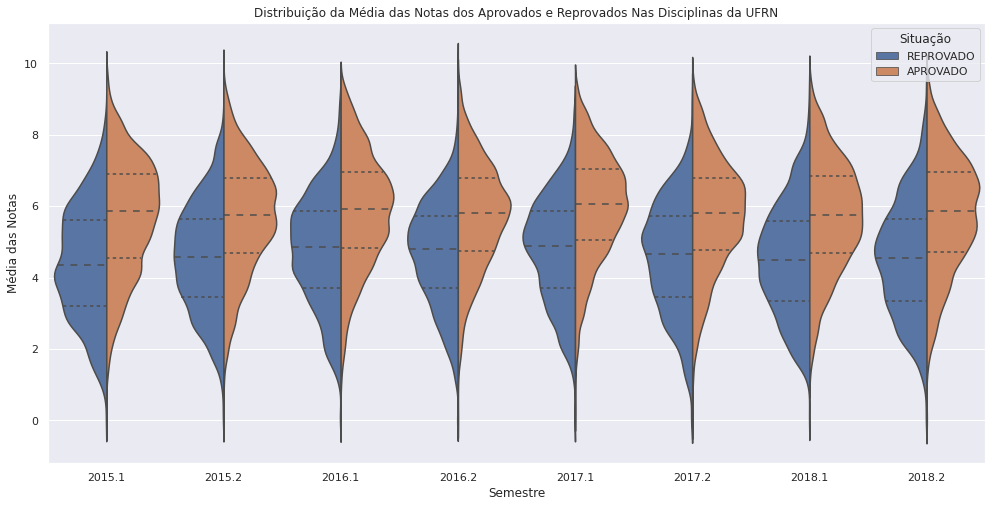

In [27]:
ax = sns.violinplot(x = 'semestrePassado', y = 'mediaNotas', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_treino.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Média das Notas dos Aprovados e Reprovados Nas Disciplinas da UFRN')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

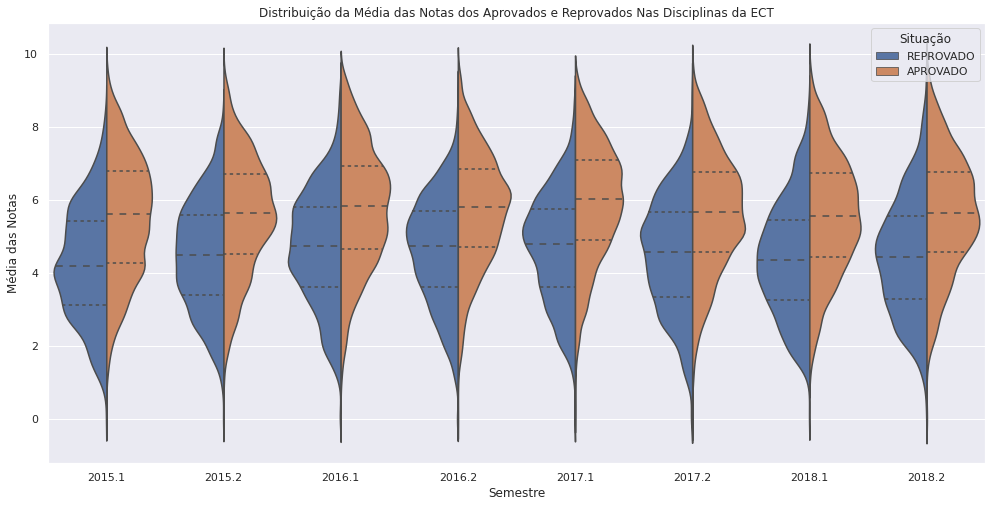

In [28]:
ax = sns.violinplot(x = 'semestrePassado', y = 'mediaNotas', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_ect.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Média das Notas dos Aprovados e Reprovados Nas Disciplinas da ECT')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

Taxa de Sucesso ao longo dos semestres

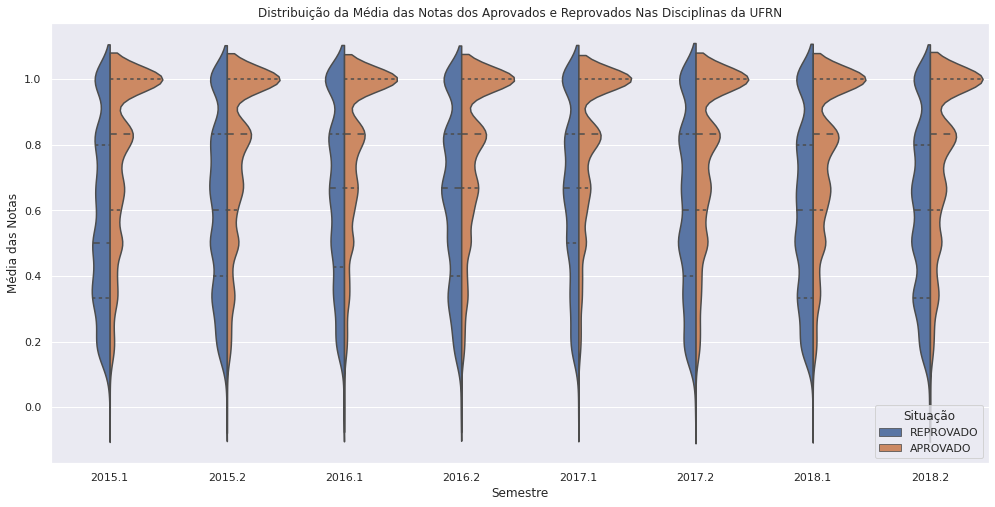

In [30]:
ax = sns.violinplot(x = 'semestrePassado', y = 'taxaDeSucesso', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_treino.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Média das Notas dos Aprovados e Reprovados Nas Disciplinas da UFRN')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

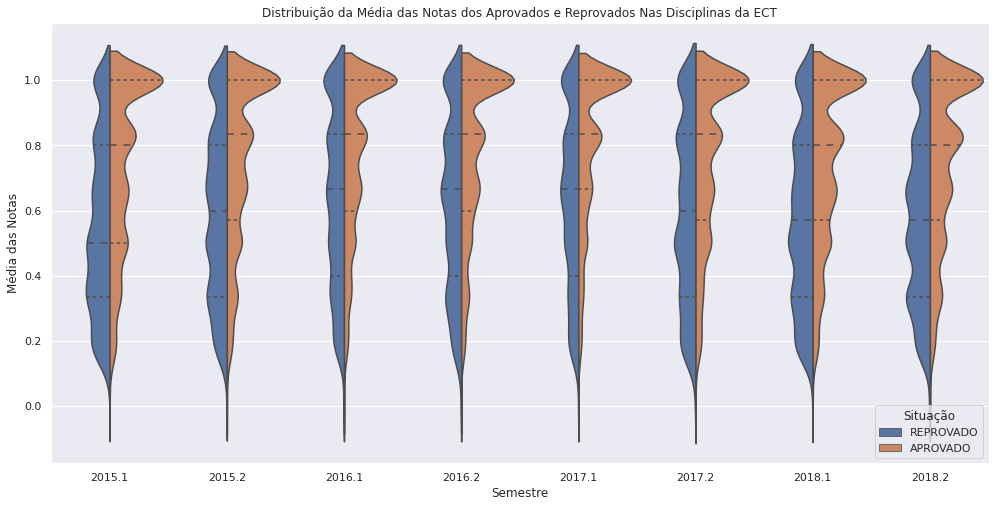

In [31]:
ax = sns.violinplot(x = 'semestrePassado', y = 'taxaDeSucesso', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_ect.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Média das Notas dos Aprovados e Reprovados Nas Disciplinas da ECT')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

Colunas a serem analisadas no gráfico

In [0]:
col_graph = ['taxaDeSucesso','mediaAprovadas','mediaReprovadas','mediaNotas','menorNota','maiorNota']                                                                                                                                                                                                 

In [0]:
df_graph_ect = df_ect.groupby(by=['semestrePassado','matricula']).mean()[col_graph].reset_index()

In [0]:
df_graph = df_treino.groupby(by=['semestrePassado','matricula']).mean()[col_graph].reset_index()

In [37]:
df_graph.head(2)

,semestrePassado,matricula,taxaDeSucesso,mediaAprovadas,mediaReprovadas,mediaNotas,menorNota,maiorNota
0,2015.1,2009028457,0.5,5.900000,2.0,3.950000,0.0,6.1
1,2015.1,2009029488,0.5,6.266667,1.8,4.033333,0.0,7.2


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


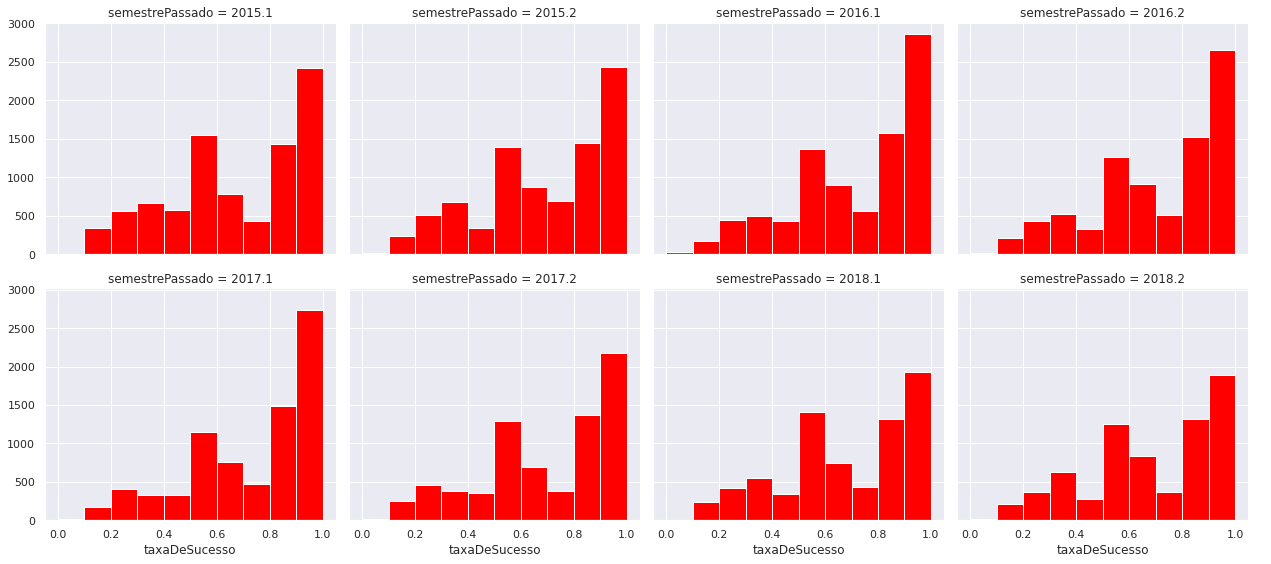

In [43]:
x = sns.FacetGrid(df_ect, col = 'semestrePassado',margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.hist,'taxaDeSucesso',color="red").add_legend())